<a href="https://colab.research.google.com/github/bipinKrishnan/fastai_course/blob/master/classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
path = input(str("Enter the base path of images: "))

In [421]:
import torch
from torchvision import models
from torch import optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from tqdm.notebook import tqdm

In [372]:
path = '/content/animal/'
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(5, 5, 7),
    transforms.Resize((128, 128)), 
    transforms.ToTensor(),
])

In [ ]:
!rm -r $path/.ipynb_checkpoints

In [374]:
def load_dataset(path=path, bs=1, transform=transform, train=True):
  imgs = ImageFolder(root=path, transform=transform)
  load_dataset.target = imgs.classes

  dataloader = DataLoader(imgs, bs, shuffle=train)

  return dataloader

def show_batch(dataloader, rows, cols):
  
  for i, (img, label) in enumerate(dataloader):
    plt.subplot(rows, cols, i+1)
    plt.imshow(np.squeeze(np.transpose(img[0].numpy(), (1, 2, 0))))
    plt.title(load_dataset.target[label[0].item()])
    plt.xticks([])
    plt.yticks([])

    if i+1 >= (rows*cols):
      break

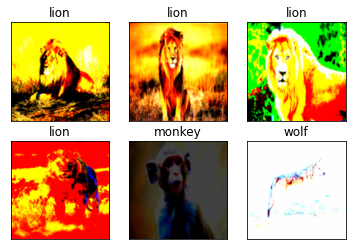

In [375]:
trainloader = load_dataset()
show_batch(trainloader, 2, 3)

In [376]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = models.resnet18(pretrained=True)

In [377]:
for params in model.parameters():
  params.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 3)
model = model.to(device)

In [378]:
for params in model.parameters():
  if params.requires_grad == True:
    print(params.shape)

torch.Size([3, 512])
torch.Size([3])


In [383]:
criterion = torch.nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(), lr=0.0001)

In [384]:
epochs = 50

model.train()
for epoch in tqdm(range(epochs), total=epochs):
  for img, label in trainloader:
    img, label = img.to(device), label.to(device)
    opt.zero_grad()

    out = model(img)

    loss = criterion(out, label)

    loss.backward()

    opt.step()
  
  if epoch >= epochs-10:
    print("Epoch: {}  Loss: {}".format(epoch+1, loss.item()))

Epoch: 41  Loss: 0.9712520837783813
Epoch: 42  Loss: 1.0141806602478027
Epoch: 43  Loss: 1.1387158632278442
Epoch: 44  Loss: 0.9769413471221924
Epoch: 45  Loss: 1.0514166355133057
Epoch: 46  Loss: 0.9219629168510437
Epoch: 47  Loss: 1.123488426208496
Epoch: 48  Loss: 1.069161295890808
Epoch: 49  Loss: 0.8701494336128235
Epoch: 50  Loss: 1.0206108093261719



In [385]:
def model_predict(img_path):
  transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    ])
  
  test_img = Image.open(img_path)
  test_img = transform(test_img).to(device)

  model_predict.prob = model(test_img.unsqueeze(0))
  
  return load_dataset.target[torch.max(model_predict.prob, 1)[1].item()]

In [386]:
lion = '/content/animal/lion/01-lion-populations-nationalgeographic_1777804.jpg'
lion1 = '/content/animal_test/unnamed.jpg'
wolf = '/content/animal/wolf/1200px-Canis_lupus_occidentalis.jpg'
wolf1 = '/content/animal_test/Kolmården_Wolf.jpg'
monkey = '/content/animal/monkey/20181112-SHANK3monkey-844.jpg'
monkey1 = '/content/animal_test/monkey.jpg'

test_set = [lion, lion1, wolf, wolf1, monkey, monkey1]

for img in test_set:
  print(model_predict(img), model_predict.prob)

lion tensor([[0.7544, 0.6199, 0.3345]], device='cuda:0', grad_fn=<AddmmBackward>)
lion tensor([[0.6707, 0.5235, 0.4834]], device='cuda:0', grad_fn=<AddmmBackward>)
wolf tensor([[0.5442, 0.5914, 0.6353]], device='cuda:0', grad_fn=<AddmmBackward>)
wolf tensor([[0.4920, 0.6069, 0.6737]], device='cuda:0', grad_fn=<AddmmBackward>)
monkey tensor([[0.4284, 0.7727, 0.3812]], device='cuda:0', grad_fn=<AddmmBackward>)
lion tensor([[0.5469, 0.5445, 0.5380]], device='cuda:0', grad_fn=<AddmmBackward>)


In [387]:
model_path = '/content/model.pt'
model_state_path = '/content/model_state.pt'

torch.save(model, model_path)
torch.save(model.state_dict(), model_state_path)

In [388]:
model = torch.load(model_path)
model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [391]:
model_predict(monkey)

'monkey'

### Deployment

In [445]:
import ipywidgets as widgets
from IPython.display import display
import io

In [472]:
def deployed_model(img):
  model.eval()
  transform = transforms.Compose([
                                  transforms.Resize((128, 128)),
                                  transforms.ToTensor()
  ])

  img = transform(img).to(device)

  return load_dataset.target[torch.max(model(img.unsqueeze(0)), 1)[1].item()]



In [492]:
img = widgets.FileUpload()
display(img)

FileUpload(value={}, description='Upload')

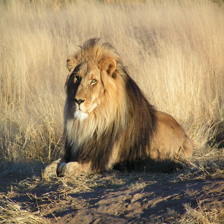

'monkey'

In [493]:
img = Image.open(io.BytesIO(img.data[0]))
display(img.resize((224, 224)))
deployed_model(img)